## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть на датасете fashion-mnist
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### AlexNet — свёрточная нейронная сеть для классификации изображений

![image](img/AlexNet-1-1.png)
AlexNet — сверточная нейронная сеть, которая оказала большое влияние на развитие машинного обучения, в особенности — на алгоритмы компьютерного зрения. 

**Особенности AlexNet**
1. Как функция активации используется Relu вместо арктангенса для добавления в модель нелинейности. За счет этого при одинаковой точности метода скорость становится в 6 раз быстрее.
2. Использование дропаута вместо регуляризации решает проблему переобучения. Однако время обучения удваивается с показателем дропаута 0,5.
3. Производится перекрытие объединений для уменьшения размера сети. За счет этого уровень ошибок первого и пятого уровней снижаются до 0,4% и 0,3%, соответственно.

**Архитектура**
![image](img/Capture-12-1.jpg)
AlexNet содержит восемь слоев с весовыми коэффициентами. Первые пять из них сверточные, а остальные три — полносвязные. Выходные данные пропускаются через функцию потерь softmax, которая формирует распределение 1000 меток классов. Сеть максимизирует многолинейную логистическую регрессию, что эквивалентно максимизации среднего по всем обучающим случаям логарифма вероятности правильной маркировки по распределению ожидания. Ядра второго, четвертого и пятого сверточных слоев связаны только с теми картами ядра в предыдущем слое, которые находятся на одном и том же графическом процессоре. Ядра третьего сверточного слоя связаны со всеми картами ядер второго слоя. Нейроны в полносвязных слоях связаны со всеми нейронами предыдущего слоя.

Таким образом, AlexNet содержит 5 сверточных слоев и 3 полносвязных слоя. Relu применяется после каждого сверточного и полносвязного слоя. Дропаут применяется перед первым и вторым полносвязными слоями. Сеть содержит 62,3 миллиона параметров и затрачивает 1,1 миллиарда вычислений при прямом проходе.  Сверточные слои, на которые приходится 6% всех параметров, производят 95% вычислений.

### Загрузка данных

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Изучение датасета

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [7]:
y_train.shape

(50000, 1)

In [8]:
x_test.shape

(10000, 32, 32, 3)

In [9]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [10]:
y_test.shape

(10000, 1)

### Построение модели

In [11]:
# Normalizing
x_train = x_train / 255
x_test = x_test / 255

# One hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

![image](img/models.png)

In [12]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Model - 1

In [13]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [14]:
model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [15]:
%%time
history = model.fit(x_train, y_train_cat, epochs=20, validation_data=(x_test, y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.4826 - accuracy: 0.4655 - val_loss: 1.2864 - val_accuracy: 0.5297
Epoch 2/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1524 - accuracy: 0.5941 - val_loss: 1.0858 - val_accuracy: 0.6146
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9996 - accuracy: 0.6498 - val_loss: 1.0423 - val_accuracy: 0.6317
Epoch 4/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8910 - accuracy: 0.6889 - val_loss: 0.9573 - val_accuracy: 0.6711
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8033 - accuracy: 0.7191 - val_loss: 0.9189 - val_accuracy: 0.6884
Epoch 6/20
1563/1563 [==============================] - 16s 11ms/step - loss: 0.7205 - accuracy: 0.7475 - val_loss: 0.9298 - val_accuracy: 0.6846
Epoch 7/20
1563/1563 [==============================] - 16s 11ms/step - loss: 0.6556 - accuracy: 0.7706 - val_loss: 0.8994 -

In [16]:
score_train = model.evaluate(x_train, y_train_cat, verbose=0)
score_test = model.evaluate(x_test, y_test_cat, verbose=0)

In [17]:
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

Train loss: 0.11488586664199829
Train accuracy: 0.9600399732589722
Test loss: 1.9462370872497559
Test accuracy: 0.671999990940094


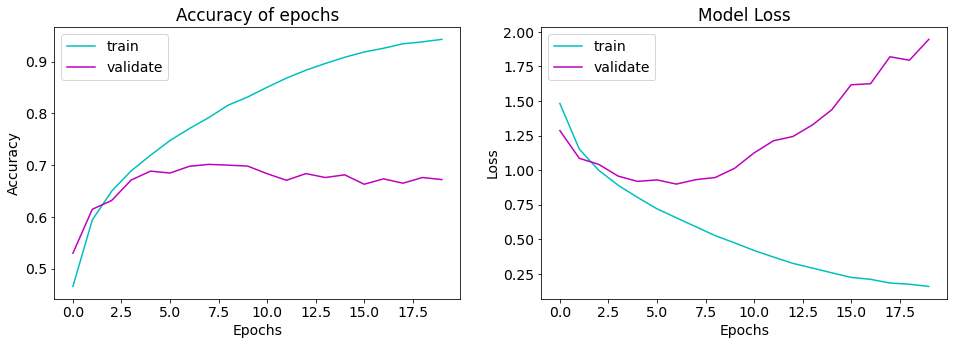

In [18]:
plot_model(history)

### Model - 2

In [19]:
# Add Drop out
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25), # Drop 25% of the units from the layer
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [20]:
model_2.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [21]:
%%time
history_2 = model_2.fit(x_train, y_train_cat, epochs=20, validation_data=(x_test, y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 18s 12ms/step - loss: 1.5704 - accuracy: 0.4278 - val_loss: 1.3789 - val_accuracy: 0.5106
Epoch 2/20
1563/1563 [==============================] - 18s 11ms/step - loss: 1.2886 - accuracy: 0.5430 - val_loss: 1.2303 - val_accuracy: 0.5642
Epoch 3/20
1563/1563 [==============================] - 18s 11ms/step - loss: 1.1696 - accuracy: 0.5839 - val_loss: 1.0696 - val_accuracy: 0.6286
Epoch 4/20
1563/1563 [==============================] - 18s 11ms/step - loss: 1.0811 - accuracy: 0.6182 - val_loss: 1.0088 - val_accuracy: 0.6464
Epoch 5/20
1563/1563 [==============================] - 18s 11ms/step - loss: 1.0104 - accuracy: 0.6447 - val_loss: 1.0000 - val_accuracy: 0.6476
Epoch 6/20
1563/1563 [==============================] - 18s 11ms/step - loss: 0.9538 - accuracy: 0.6641 - val_loss: 0.9247 - val_accuracy: 0.6755
Epoch 7/20
1563/1563 [==============================] - 18s 11ms/step - loss: 0.9070 - accuracy: 0.6818 - val_loss: 0.9158 -

In [22]:
score_train_2 = model_2.evaluate(x_train, y_train_cat, verbose=0)
score_test_2 = model_2.evaluate(x_test, y_test_cat, verbose=0)

In [23]:
print('Train loss:', score_train_2[0])
print('Train accuracy:', score_train_2[1])
print('Test loss:', score_test_2[0])
print('Test accuracy:', score_test_2[1])

Train loss: 0.412823349237442
Train accuracy: 0.8686800003051758
Test loss: 0.9147502779960632
Test accuracy: 0.6941999793052673


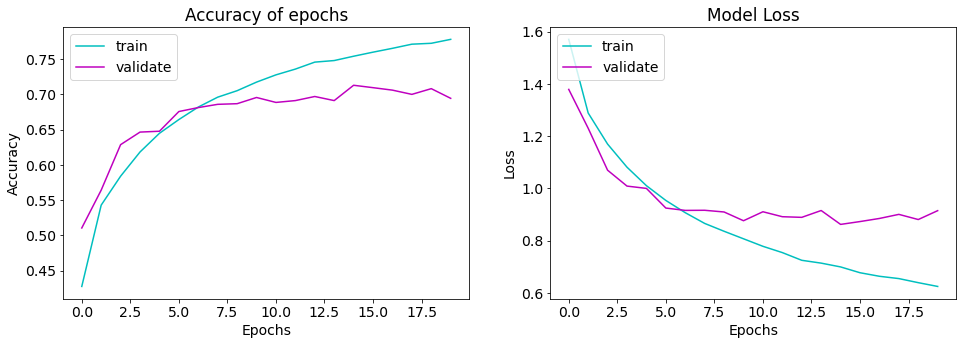

In [24]:
plot_model(history_2)

### Model - 3

In [25]:
# Add More layers with more filters
model_3 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [26]:
model_3.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [27]:
%%time
history_3 = model_3.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 123s 79ms/step - loss: 1.5582 - accuracy: 0.4246 - val_loss: 1.3076 - val_accuracy: 0.5352
Epoch 2/50
1563/1563 [==============================] - 124s 79ms/step - loss: 1.1603 - accuracy: 0.5859 - val_loss: 0.9721 - val_accuracy: 0.6566
Epoch 3/50
1563/1563 [==============================] - 125s 80ms/step - loss: 0.9843 - accuracy: 0.6517 - val_loss: 0.8730 - val_accuracy: 0.6945
Epoch 4/50
1563/1563 [==============================] - 129s 83ms/step - loss: 0.8801 - accuracy: 0.6877 - val_loss: 0.8734 - val_accuracy: 0.6976
Epoch 5/50
1563/1563 [==============================] - 126s 81ms/step - loss: 0.8115 - accuracy: 0.7133 - val_loss: 0.7714 - val_accuracy: 0.7389
Epoch 6/50
1563/1563 [==============================] - 124s 79ms/step - loss: 0.7443 - accuracy: 0.7380 - val_loss: 0.7933 - val_accuracy: 0.7304
Epoch 7/50
1563/1563 [==============================] - 126s 81ms/step - loss: 0.7031 - accuracy: 0.7524 - val_loss: 0

In [28]:
score_train_3 = model_3.evaluate(x_train, y_train_cat, verbose=0)
score_test_3 = model_3.evaluate(x_test, y_test_cat, verbose=0)

In [29]:
print('Train loss:', score_train_3[0])
print('Train accuracy:', score_train_3[1])
print('Test loss:', score_test_3[0])
print('Test accuracy:', score_test_3[1])

Train loss: 0.036806464195251465
Train accuracy: 0.9914399981498718
Test loss: 0.9626681804656982
Test accuracy: 0.767300009727478


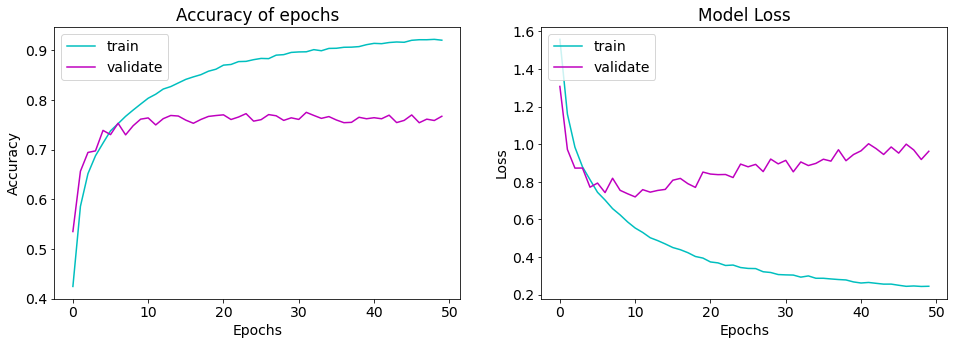

In [30]:
plot_model(history_3)

### Model - 4

In [13]:
# Increased layers and Filters along with Increased dropout
model_4 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [14]:
model_4.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [15]:
%%time
history_4 = model_4.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 301s 193ms/step - loss: 1.7437 - accuracy: 0.3503 - val_loss: 1.2784 - val_accuracy: 0.5388
Epoch 2/50
1563/1563 [==============================] - 287s 184ms/step - loss: 1.2982 - accuracy: 0.5356 - val_loss: 1.0367 - val_accuracy: 0.6313
Epoch 3/50
1563/1563 [==============================] - 272s 174ms/step - loss: 1.1072 - accuracy: 0.6090 - val_loss: 0.9213 - val_accuracy: 0.6745
Epoch 4/50
1563/1563 [==============================] - 284s 182ms/step - loss: 1.0056 - accuracy: 0.6495 - val_loss: 0.8321 - val_accuracy: 0.7094
Epoch 5/50
1563/1563 [==============================] - 307s 197ms/step - loss: 0.9383 - accuracy: 0.6780 - val_loss: 0.7843 - val_accuracy: 0.7262
Epoch 6/50
1563/1563 [==============================] - 286s 183ms/step - loss: 0.8849 - accuracy: 0.6927 - val_loss: 0.8099 - val_accuracy: 0.7218
Epoch 7/50
1563/1563 [==============================] - 314s 201ms/step - loss: 0.8557 - accuracy: 0.7062 - val_

In [16]:
score_train_4 = model_4.evaluate(x_train, y_train_cat, verbose=0)
score_test_4 = model_4.evaluate(x_test, y_test_cat, verbose=0)

In [17]:
print('Train loss:', score_train_4[0])
print('Train accuracy:', score_train_4[1])
print('Test loss:', score_test_4[0])
print('Test accuracy:', score_test_4[1])

Train loss: 0.34661126136779785
Train accuracy: 0.8815400004386902
Test loss: 0.6320710182189941
Test accuracy: 0.8080999851226807


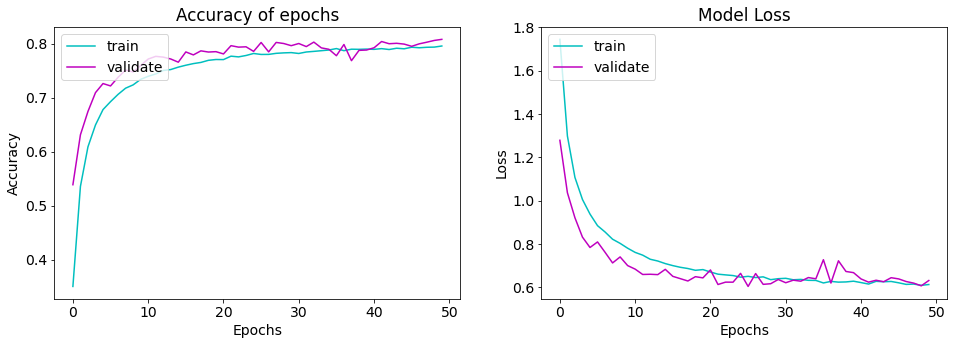

In [18]:
plot_model(history_4)

### Model - 5

In [19]:
# Adding Batch Normalization
model_5 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [20]:
model_5.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
%%time
history_5 = model_5.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 360s 230ms/step - loss: 1.5982 - accuracy: 0.4452 - val_loss: 1.1978 - val_accuracy: 0.5743
Epoch 2/50
1563/1563 [==============================] - 360s 230ms/step - loss: 1.0653 - accuracy: 0.6244 - val_loss: 0.8982 - val_accuracy: 0.6801
Epoch 3/50
1563/1563 [==============================] - 381s 243ms/step - loss: 0.8977 - accuracy: 0.6870 - val_loss: 0.7461 - val_accuracy: 0.7390
Epoch 4/50
1563/1563 [==============================] - 393s 251ms/step - loss: 0.7970 - accuracy: 0.7264 - val_loss: 0.6877 - val_accuracy: 0.7604
Epoch 5/50
1563/1563 [==============================] - 372s 238ms/step - loss: 0.7138 - accuracy: 0.7565 - val_loss: 0.6653 - val_accuracy: 0.7696
Epoch 6/50
1563/1563 [==============================] - 375s 240ms/step - loss: 0.6557 - accuracy: 0.7769 - val_loss: 0.5841 - val_accuracy: 0.7983
Epoch 7/50
1563/1563 [==============================] - 355s 227ms/step - loss: 0.6117 - accuracy: 0.7902 - val_

In [ ]:
score_train_5 = model_5.evaluate(x_train, y_train_cat, verbose=0)
score_test_5 = model_5.evaluate(x_test, y_test_cat, verbose=0)

In [ ]:
print('Train loss:', score_train_5[0])
print('Train accuracy:', score_train_5[1])
print('Test loss:', score_test_5[0])
print('Test accuracy:', score_test_5[1])

In [ ]:
plot_model(history_5)

### Model - 6

In [ ]:
# ImageDataGenerator
model_6 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [ ]:
model_6.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
%%time
history_6 = model_6.fit_generator(datagen.flow(x_train, y_train_cat, batch_size = 64),
                                 validation_data = (x_test, y_test_cat),
                                 steps_per_epoch = x_train.shape[0] // 64, 
                                 epochs = 50, verbose = 1,
                                 callbacks = callback_list)

In [ ]:
score_train_6 = model_6.evaluate(x_train, y_train_cat, verbose=0)
score_test_6 = model_6.evaluate(x_test, y_test_cat, verbose=0)

In [ ]:
print('Train loss:', score_train_6[0])
print('Train accuracy:', score_train_6[1])
print('Test loss:', score_test_6[0])
print('Test accuracy:', score_test_6[1])

In [ ]:
plot_model(history_6)

### Results

In [ ]:
results = pd.DataFrame({'model_1': score_test, 'model_2': score_test_2, 'model_3': score_test_3,
                        'model_4': score_test_4, 'model_5': score_test_5, 'model_6': score_test_6}).T
results.columns=['Loss', 'Accuracy']
results

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label='model-1')
plt.plot(history_2.history['accuracy'], label='model-2')
plt.plot(history_3.history['accuracy'], label='model-3')
plt.plot(history_4.history['accuracy'], label='model-4')
plt.plot(history_5.history['accuracy'], label='model-5')
plt.plot(history_6.history['accuracy'], label='model-6')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['val_accuracy'], label='model-1')
plt.plot(history_2.history['val_accuracy'], label='model-2')
plt.plot(history_3.history['val_accuracy'], label='model-3')
plt.plot(history_4.history['val_accuracy'], label='model-4')
plt.plot(history_5.history['val_accuracy'], label='model-5')
plt.plot(history_6.history['val_accuracy'], label='model-6')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

In [ ]:
model_6.summary()

Вариант 2. (сложный)
- реализовать нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

При реализации и последующем анализе сверточных моделей для текущего набора cifar10 в стиле AlexNet, мы наблюдаем, что в простых сетях, при небольшой глубине, сложности и ширине весьма низкая точность, а также присутствует эффект переобучения. Усложняя модель, мы наблюдаем обратное, увеличение точности и уменьшение эффекта переобучения(при добавлении слоя Dropout), но при всём этом существенно возрастает время обработки датасета. Значительный прирост точности даёт техника регуляризации сети - Batch normalization(авторами метода рекомендуется убирать слой Dropout при использовании .

https://www.kaggle.com/kedarsai/cifar-10-88-accuracy-using-keras  
https://www.kaggle.com/kalashnimov/keras-callbacks-with-91-acc  
https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer